#Time series of satellites measurements

##1 - Introduction

The efficient transfer of energy from solar wind into the Earth’s magnetic field causes geomagnetic storms. The resulting variations in the magnetic field increase errors in magnetic navigation. The disturbance-storm-time index, or Dst, is a measure of the severity of the geomagnetic storm.

Datasets from NASA's ACE (Advance Composition Explorer) satellite and NOAA's DSCOVR (Deep Space Climate Observatory) were chosen.

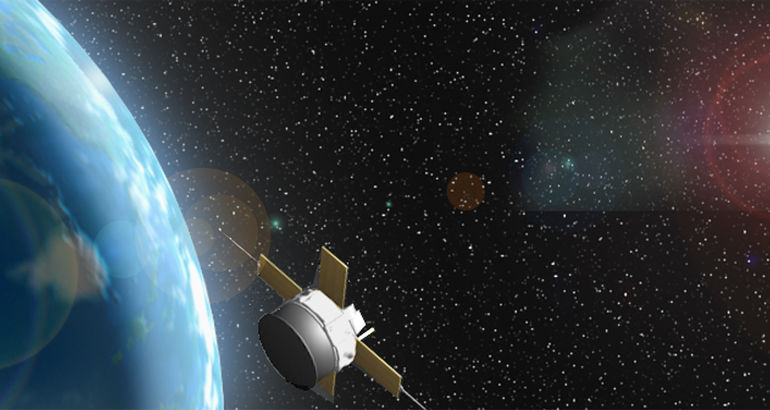
---
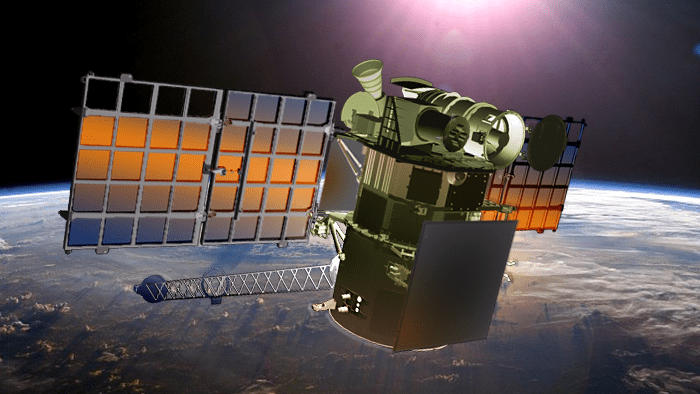


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import pytz
import os
import gdown
import matplotlib.pyplot as plt
from matplotlib import style
import statsmodels.api as sm
from pandas import DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sbn
from IPython.display import Image
from IPython.core.display import HTML
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import signal
import scipy.stats as stats
from math import sqrt
from sklearn.metrics import mean_squared_error

##2 - Dataset load and preprocessing

In [4]:
# Descargar la carpeta de dataset
if os.access('solar_wind.csv', os.F_OK) is False:
  url = 'https://drive.google.com/file/d/1nVnIaURAmI0EgBtrUriFkU_f1vTKytzu/view?usp=sharing'
  output = 'solar_wind.csv'
  gdown.download(url, output, quiet=False, fuzzy=True)  #Agregé fuzzy=True porque estoy copiando la URL desde google drive
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1nVnIaURAmI0EgBtrUriFkU_f1vTKytzu
To: /content/solar_wind.csv
100%|██████████| 916M/916M [00:05<00:00, 175MB/s]


In [5]:
Dataset = pd.read_csv("/content/solar_wind.csv")

In [6]:
Dataset.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [7]:
Dataset.tail()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
8392315,train_c,2435 days 23:55:00,-1.18,2.00,-3.92,-59.28,120.51,-1.17,2.98,-3.23,-45.24,111.48,4.56,4.64,348.73,23368.0,ac
8392316,train_c,2435 days 23:56:00,-1.34,2.12,-3.83,-56.78,122.23,-1.33,3.08,-3.12,-42.95,113.45,4.58,4.27,346.36,26497.0,ac
8392317,train_c,2435 days 23:57:00,-1.62,2.33,-3.63,-51.98,124.76,-1.61,3.22,-2.87,-38.57,116.58,4.61,3.95,344.12,27050.0,ac
8392318,train_c,2435 days 23:58:00,-2.27,2.48,-3.22,-43.81,132.50,-2.26,3.25,-2.44,-31.61,124.81,4.65,2.81,338.52,33257.0,ac
8392319,train_c,2435 days 23:59:00,-2.15,2.41,-3.30,-45.55,131.76,-2.15,3.21,-2.53,-33.21,123.75,4.62,2.30,342.31,32267.0,ac


Since the dataset has 3 data trains, and since the entire dataset contains 8M3 of data, I choose to keep only train_a.

In [8]:
Dataset_A = Dataset.loc[Dataset['period']=='train_a']

In [9]:
Dataset_A.tail()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
1729435,train_a,1200 days 23:55:00,-4.07,3.06,-1.54,-16.78,143.08,-4.07,3.39,-0.47,-5.09,140.20,5.32,6.05,339.02,43507.0,ac
1729436,train_a,1200 days 23:56:00,-3.35,3.40,-1.43,-16.63,134.59,-3.35,3.68,-0.26,-2.98,132.32,4.98,5.37,338.51,42298.0,ac
1729437,train_a,1200 days 23:57:00,-3.27,3.42,-1.29,-15.22,133.66,-3.27,3.65,-0.12,-1.42,131.78,4.90,5.18,342.72,38547.0,ac
1729438,train_a,1200 days 23:58:00,-3.26,3.47,-1.07,-12.72,133.19,-3.25,3.63,0.09,1.11,131.87,4.88,5.60,338.74,42813.0,ac
1729439,train_a,1200 days 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Addition of a datetime column as index.

In [10]:
Dataset_A["Date-Time"] = pd.date_range(start='9/1/2002', periods=len(Dataset_A), freq='min')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
Dataset_A['Date-Time'].dt.tz_localize(None)
Dataset_A.index = Dataset_A['Date-Time']
Dataset_A.index

DatetimeIndex(['2002-09-01 00:00:00', '2002-09-01 00:01:00',
               '2002-09-01 00:02:00', '2002-09-01 00:03:00',
               '2002-09-01 00:04:00', '2002-09-01 00:05:00',
               '2002-09-01 00:06:00', '2002-09-01 00:07:00',
               '2002-09-01 00:08:00', '2002-09-01 00:09:00',
               ...
               '2005-12-14 23:50:00', '2005-12-14 23:51:00',
               '2005-12-14 23:52:00', '2005-12-14 23:53:00',
               '2005-12-14 23:54:00', '2005-12-14 23:55:00',
               '2005-12-14 23:56:00', '2005-12-14 23:57:00',
               '2005-12-14 23:58:00', '2005-12-14 23:59:00'],
              dtype='datetime64[ns]', name='Date-Time', length=1729440, freq=None)

##3 - Analysis and description of the dataset.

In [12]:
Dataset_A

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source,Date-Time
Date-Time,,,,,,,,,,,,,,,,,,
2002-09-01 00:00:00,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac,2002-09-01 00:00:00
2002-09-01 00:01:00,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac,2002-09-01 00:01:00
2002-09-01 00:02:00,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac,2002-09-01 00:02:00
2002-09-01 00:03:00,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac,2002-09-01 00:03:00
2002-09-01 00:04:00,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac,2002-09-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-14 23:55:00,train_a,1200 days 23:55:00,-4.07,3.06,-1.54,-16.78,143.08,-4.07,3.39,-0.47,-5.09,140.20,5.32,6.05,339.02,43507.0,ac,2005-12-14 23:55:00
2005-12-14 23:56:00,train_a,1200 days 23:56:00,-3.35,3.40,-1.43,-16.63,134.59,-3.35,3.68,-0.26,-2.98,132.32,4.98,5.37,338.51,42298.0,ac,2005-12-14 23:56:00
2005-12-14 23:57:00,train_a,1200 days 23:57:00,-3.27,3.42,-1.29,-15.22,133.66,-3.27,3.65,-0.12,-1.42,131.78,4.90,5.18,342.72,38547.0,ac,2005-12-14 23:57:00


In [13]:
Dataset_A.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1729440 entries, 2002-09-01 00:00:00 to 2005-12-14 23:59:00
Data columns (total 18 columns):
 #   Column       Dtype         
---  ------       -----         
 0   period       object        
 1   timedelta    object        
 2   bx_gse       float64       
 3   by_gse       float64       
 4   bz_gse       float64       
 5   theta_gse    float64       
 6   phi_gse      float64       
 7   bx_gsm       float64       
 8   by_gsm       float64       
 9   bz_gsm       float64       
 10  theta_gsm    float64       
 11  phi_gsm      float64       
 12  bt           float64       
 13  density      float64       
 14  speed        float64       
 15  temperature  float64       
 16  source       object        
 17  Date-Time    datetime64[ns]
dtypes: datetime64[ns](1), float64(14), object(3)
memory usage: 250.7+ MB


The dataset contains 1729440 records with 14 columns of measurements made by the satellite, starting on 09/01/2002 and the last one corresponding to 12/14/2005. This corresponds to 1200 days of measurements. Measurements are with a time interval of 1 minute.

In [14]:
dosdias = Dataset_A.loc['24/09/2004 00:00:00':'25/09/2004 23:59:00']

In [15]:
diezdias = Dataset_A.loc['20/09/2004 00:00:00':'30/09/2004 23:59:00']

In [16]:
diezdias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15840 entries, 2004-09-20 00:00:00 to 2004-09-30 23:59:00
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   period       15840 non-null  object        
 1   timedelta    15840 non-null  object        
 2   bx_gse       15437 non-null  float64       
 3   by_gse       15437 non-null  float64       
 4   bz_gse       15437 non-null  float64       
 5   theta_gse    15437 non-null  float64       
 6   phi_gse      15437 non-null  float64       
 7   bx_gsm       15437 non-null  float64       
 8   by_gsm       15437 non-null  float64       
 9   bz_gsm       15437 non-null  float64       
 10  theta_gsm    15437 non-null  float64       
 11  phi_gsm      15437 non-null  float64       
 12  bt           15437 non-null  float64       
 13  density      14690 non-null  float64       
 14  speed        14690 non-null  float64       
 15  temperature  14356

The dataset trimmed to 10 days contains 351,360 records with 14 columns of measurements made by the satellite, starting on 09/01/2002 and the last one corresponding to 10/10/2002.

In [17]:
docemeses=Dataset_A.loc['01/09/2004 00:00:00':'30/08/2005 23:59:00']

In [18]:
docemeses.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 864000 entries, 2004-01-09 00:00:00 to 2005-08-30 23:59:00
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   period       864000 non-null  object        
 1   timedelta    864000 non-null  object        
 2   bx_gse       814698 non-null  float64       
 3   by_gse       814698 non-null  float64       
 4   bz_gse       814698 non-null  float64       
 5   theta_gse    814698 non-null  float64       
 6   phi_gse      814698 non-null  float64       
 7   bx_gsm       814698 non-null  float64       
 8   by_gsm       814698 non-null  float64       
 9   bz_gsm       814698 non-null  float64       
 10  theta_gsm    814698 non-null  float64       
 11  phi_gsm      814698 non-null  float64       
 12  bt           814698 non-null  float64       
 13  density      751787 non-null  float64       
 14  speed        751816 non-null  float64       
 15  

The 1-year trimmed dataset contains 524,160 records with 14 columns of measurements made by the satellite, beginning on 09/01/2002 and the last one corresponding to 08/30/2003.

###3.1 - Selection of a variable to study  
*   bz_gse = interplanetary magnetic field in the z axis, this is perpendicular to the ecliptic and is created by waves and other disturbances in the solar wind.

In [19]:
variable = 'bz_gse'

In [20]:
#docemeses[variable].isnull()
docemeses = docemeses.interpolate(method ='ffill', limit_direction ='forward')

In [21]:
Dataset_A[variable].describe()

count    1.575012e+06
mean    -2.088664e-01
std      4.353029e+00
min     -5.305000e+01
25%     -2.660000e+00
50%     -1.700000e-01
75%      2.280000e+00
max      7.403000e+01
Name: bz_gse, dtype: float64

In [22]:
Dataset_A[Dataset_A.isnull()].count()

period         0
timedelta      0
bx_gse         0
by_gse         0
bz_gse         0
theta_gse      0
phi_gse        0
bx_gsm         0
by_gsm         0
bz_gsm         0
theta_gsm      0
phi_gsm        0
bt             0
density        0
speed          0
temperature    0
source         0
Date-Time      0
dtype: int64

In [23]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

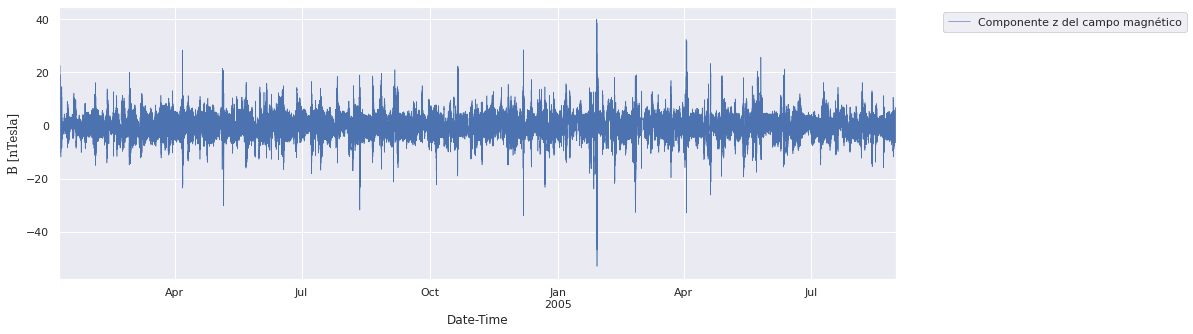

In [24]:
docemeses[variable].plot(linewidth=0.6, label="Componente z del campo magnético")#variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

In [25]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

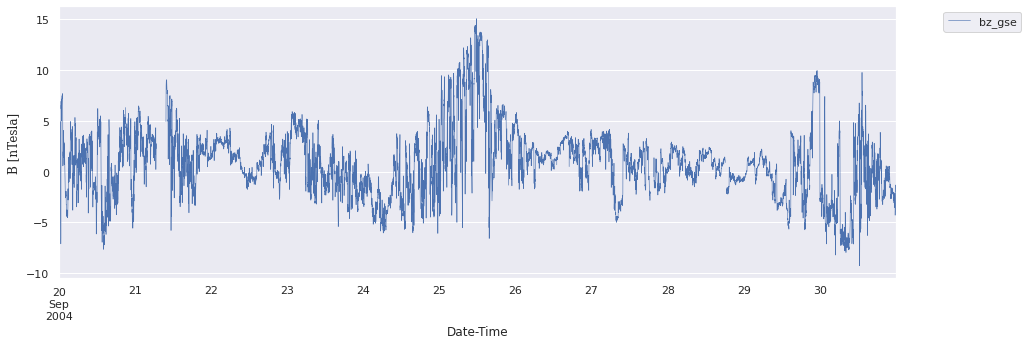

In [26]:
diezdias[variable].plot(linewidth=0.6, label=variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

In [27]:
sbn.set(rc={'figure.figsize':(15, 5)})

Text(0, 0.5, 'B [nTesla]')

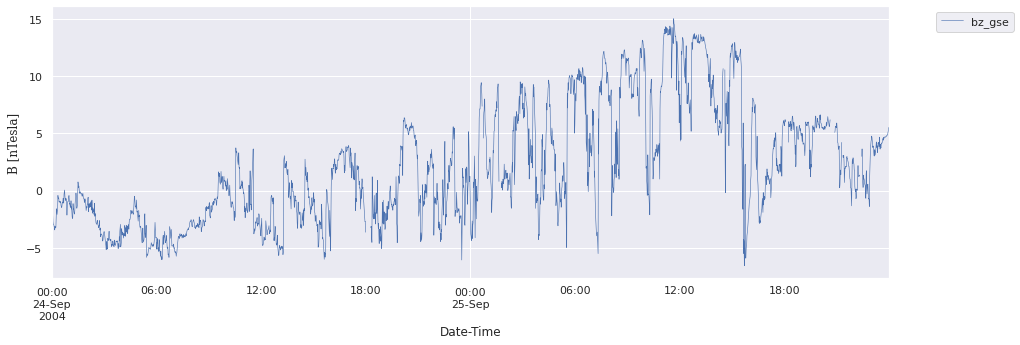

In [28]:
dosdias[variable].plot(linewidth=0.6, label=variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

I notice that I have a continuous variable, with regular samples. The maximum values are at 74.03nT and the minimum at -53.05nT. The mean is -20.88nT and its deviation is 4.35nT. It seems that the variance is not constant.

In [29]:
docemeses[variable].describe()

count    864000.000000
mean         -0.220224
std           4.488150
min         -53.050000
25%          -2.850000
50%          -0.250000
75%           2.410000
max          40.040000
Name: bz_gse, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

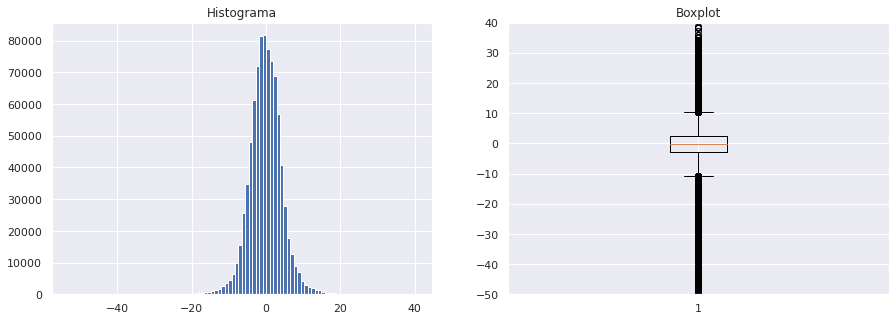

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.set_title('Histograma')
ax1.hist(docemeses[variable], bins = 100)
ax2.set_title("Boxplot")
plt.ylim(-50,40)
ax2.boxplot(docemeses[variable])
plt.show

In [31]:
# IQR
Q1 = np.percentile(docemeses[variable], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(docemeses[variable], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [32]:
# Above Upper bound
upper = docemeses[variable] >= (Q3+1.5*IQR)
print('valor máximo a partir del cual se considera outlier: ', Q3+1.5*IQR)

valor máximo a partir del cual se considera outlier:  10.3


In [33]:
# Below Lower bound
lower = docemeses[variable] <= (Q1-1.5*IQR)
print('valor mínimo a partir del cual se considera outlier: ', Q1-1.5*IQR)

valor mínimo a partir del cual se considera outlier:  -10.74


In [34]:
# Position of the Outlier
print(np.where(docemeses[variable]>10.3))

(array([  1087,   1088,   1089, ..., 861199, 861200, 861201]),)


As I have so many samples, I will make a resample in order to get a more workable dataset.

In [35]:
docemeses_resample = docemeses.resample('6h').mean()

<function matplotlib.pyplot.show(*args, **kw)>

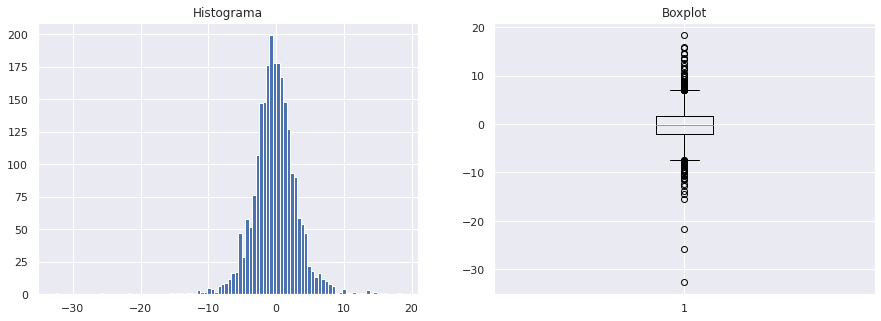

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.set_title('Histograma')
ax1.hist(docemeses_resample[variable], bins = 100)
ax2.set_title("Boxplot")
#plt.ylim(-50,40)
ax2.boxplot(docemeses_resample[variable])
plt.show

As can be seen, the variable bz_gse has a distribution that has a Gaussian distribution

###3.2 - Spectral Analysis

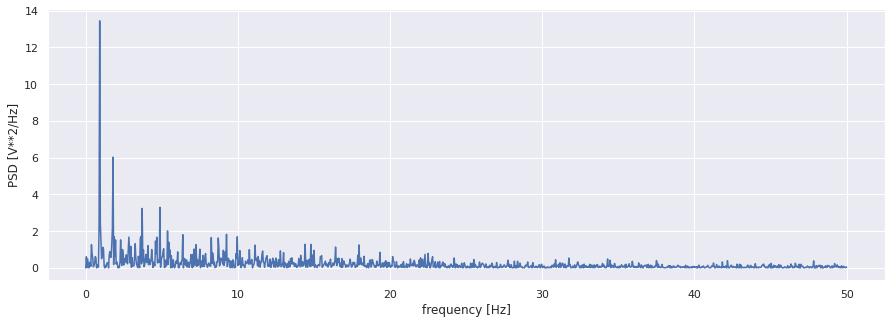

In [37]:
docemeses_sinoutliers = docemeses_resample
N = 100
G, Pyy_den = signal.periodogram(docemeses_resample[variable],N)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.plot(G, Pyy_den)
plt.show()

###3.3 - Decomposition analysis with additive model

Text(0, 0.5, 'B [nTesla]')

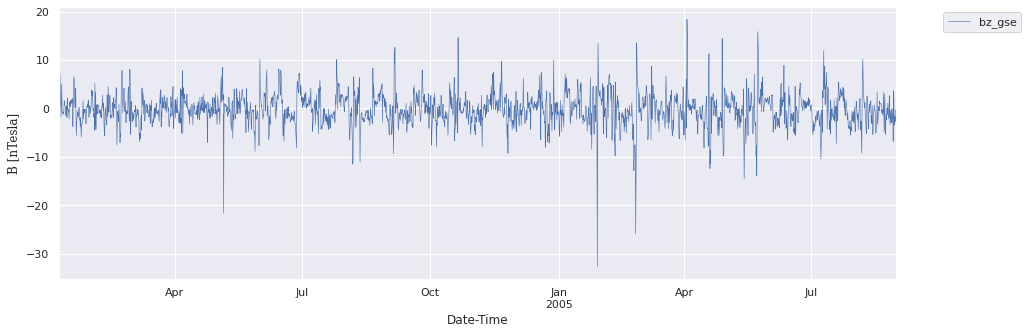

In [38]:
sbn.set(rc={'figure.figsize':(15, 5)})
docemeses_resample[variable].plot(linewidth=0.6, label=variable)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)

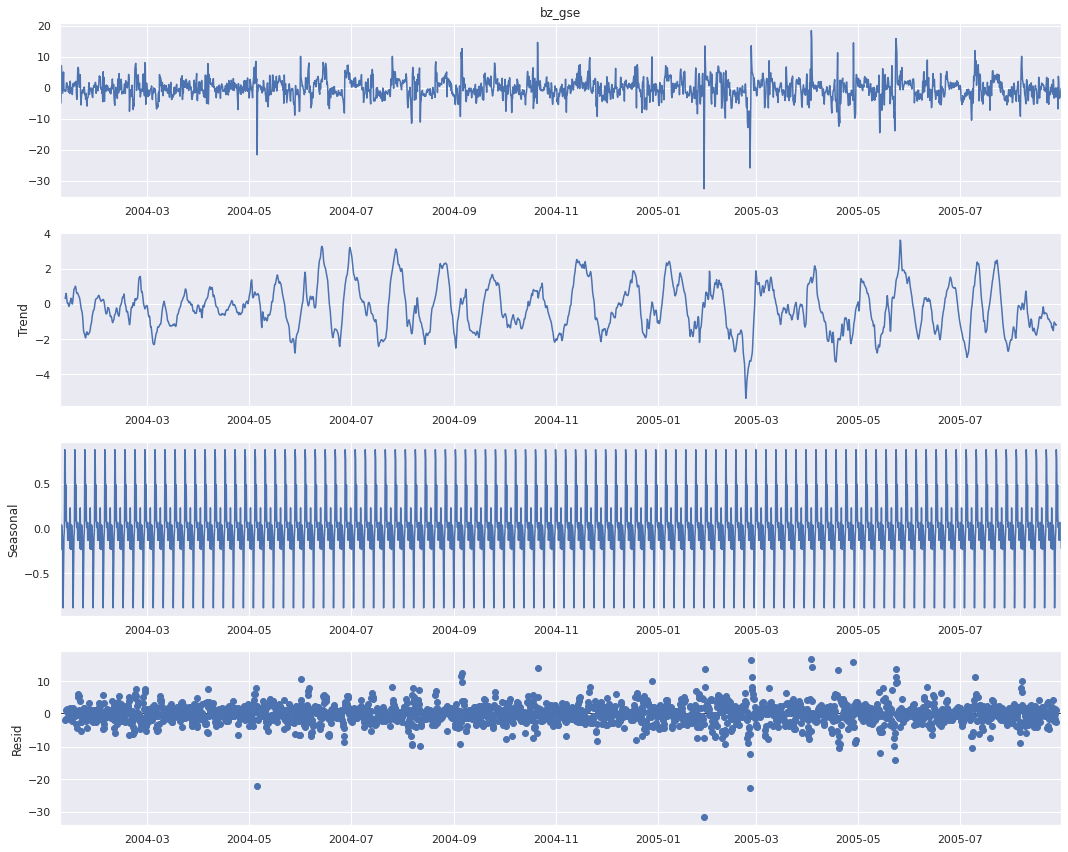

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
decomposition = sm.tsa.seasonal_decompose(docemeses_resample[variable], model='additive')
fig = decomposition.plot()
plt.show()

It is observed that the trend has clearly marked periods. In turn, the seasonal behavior is evident, with a frequency of less than one week.
The residues are mainly between -10 and 10, but there are some that reach a higher magnitude.

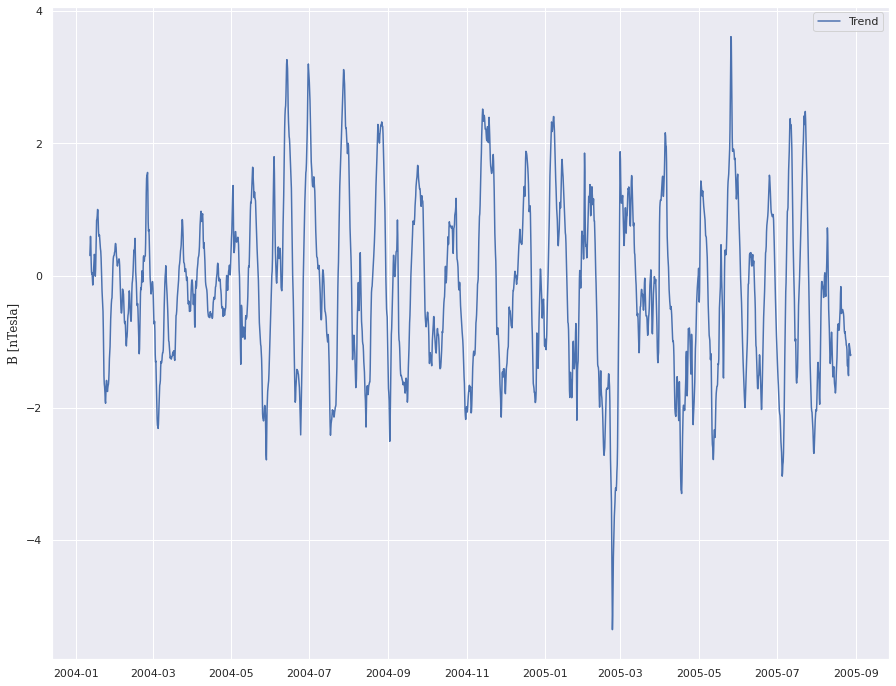

In [81]:
trend = decomposition.trend
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
plt.plot(trend, label = "Trend")
plt.legend()

###3.4 - Deterministic model fit to trend:

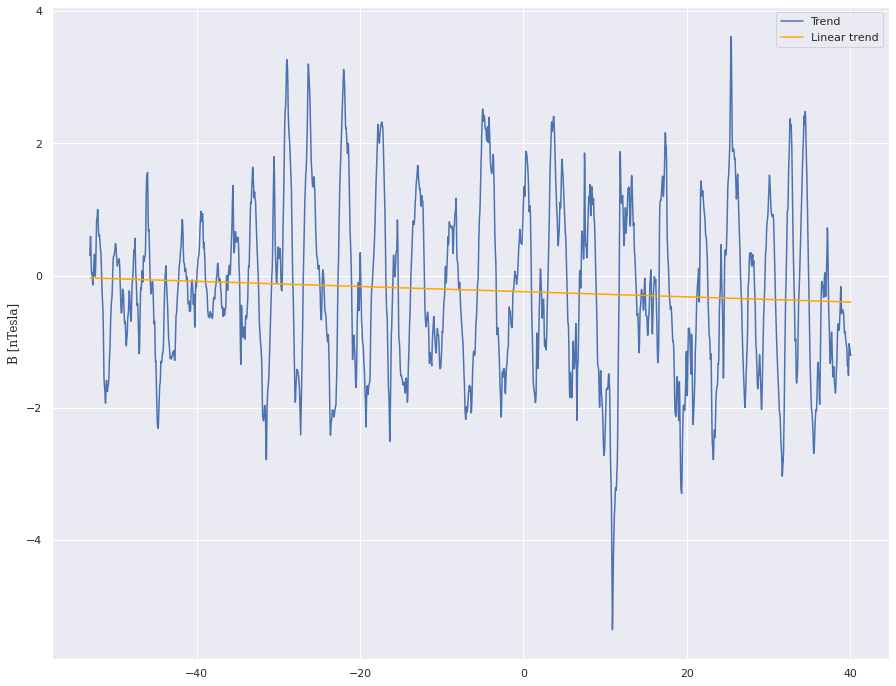

In [80]:
def objective(a,b,x):
    return a*x+b 

from scipy.optimize import curve_fit
x = np.linspace(min(docemeses[variable]), max(docemeses[variable]),2376)
y = trend.dropna(axis=0)
popt, _ = curve_fit(objective, x, y)
a, b = popt
y_line = objective(x,a,b)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
plt.plot(x,y, label = "Trend")

plt.plot(x, y_line, color = 'orange', label = "Linear trend")
plt.legend()

A decreasing linear trend is observed in the twelve months analyzed.

In [42]:
trend.isnull()

Date-Time
2004-01-09 00:00:00    True
2004-01-09 06:00:00    True
2004-01-09 12:00:00    True
2004-01-09 18:00:00    True
2004-01-10 00:00:00    True
                       ... 
2005-08-29 18:00:00    True
2005-08-30 00:00:00    True
2005-08-30 06:00:00    True
2005-08-30 12:00:00    True
2005-08-30 18:00:00    True
Freq: 6H, Name: trend, Length: 2400, dtype: bool

In [43]:
trend = trend.dropna(axis=0)
trend.isnull()

Date-Time
2004-01-12 00:00:00    False
2004-01-12 06:00:00    False
2004-01-12 12:00:00    False
2004-01-12 18:00:00    False
2004-01-13 00:00:00    False
                       ...  
2005-08-26 18:00:00    False
2005-08-27 00:00:00    False
2005-08-27 06:00:00    False
2005-08-27 12:00:00    False
2005-08-27 18:00:00    False
Freq: 6H, Name: trend, Length: 2376, dtype: bool

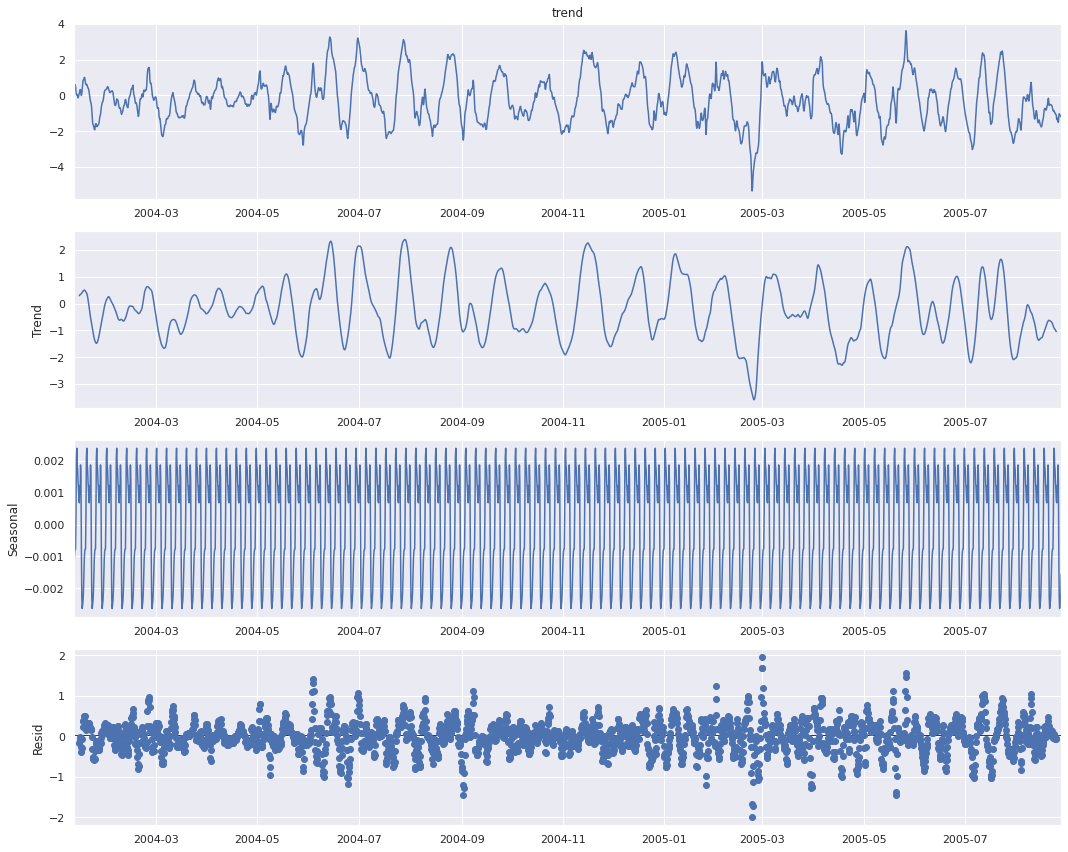

In [44]:
rcParams['figure.figsize'] = 15, 12
decomposition_2 = sm.tsa.seasonal_decompose(trend, model='additive')
fig = decomposition_2.plot()
plt.show()

In [45]:
trend_2 = decomposition_2.trend
trend_2 = trend_2.dropna(axis=0)

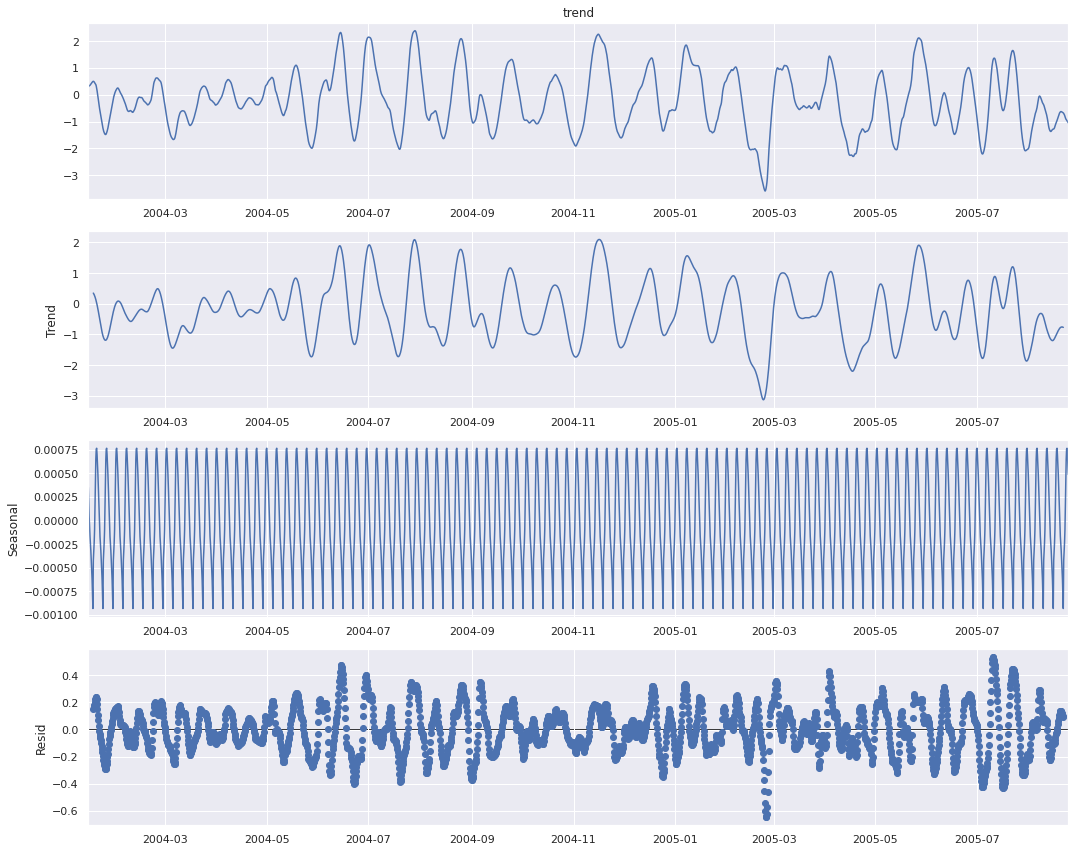

In [46]:
rcParams['figure.figsize'] = 15, 12
decomposition_3 = sm.tsa.seasonal_decompose(trend_2, model='additive')
fig = decomposition_3.plot()
plt.show()

###3.5 - Analysis of the autocorrelation

In [47]:
autocorr = sm.tsa.acf (docemeses_resample[variable],nlags = 80, fft=False, missing="drop")
partial =  sm.tsa.pacf (docemeses_resample[variable],nlags = 80)

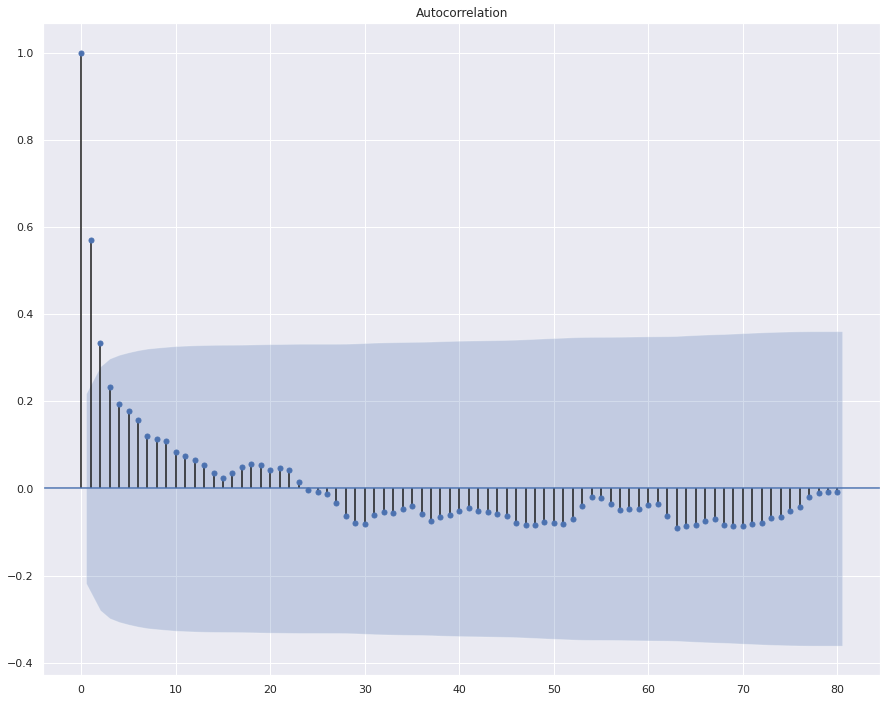

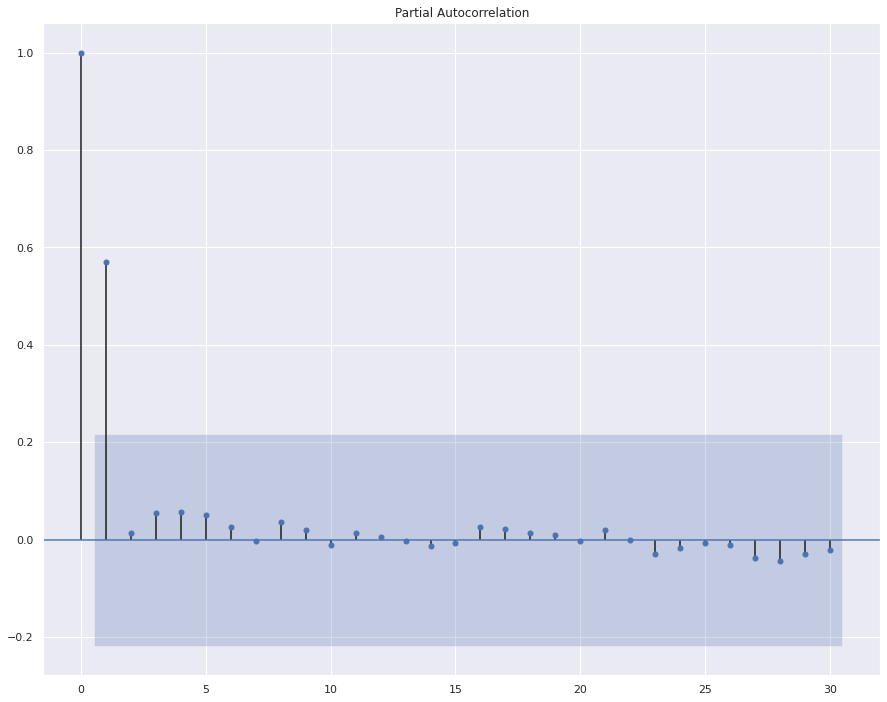

In [48]:
rcParams['figure.figsize'] = 15, 12
ax_1 = tsaplots.plot_acf(autocorr, lags = 80)
ax_2 = tsaplots.plot_pacf(autocorr, lags = 30, method = 'ywm')


It can be seen from the partial autocorrelation that the dataset has an autoregression of degree 1. In turn, from the autocorrelation it is observed that the model decays exponentially, that is, it is an AR model. For this reason, I do not see the need to differentiate.

Looking at the fixed autocorrelation MA(3)

Looking at partial autocorrelation AR(1)

###3.6 - Check if the series are stationary

Considering that a satellite has a stationary orbit, it is expected that its temperature readings will be affected by its movement relative to the earth and the sun. I will verify this below by performing the augmented Dickey-Fuller and KPSS tests.

###3.7 - Dickey-Fuller test

In [49]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [50]:
adf_test(docemeses_resample[variable])

Results of Dickey-Fuller Test:
Test Statistic                -1.305141e+01
p-value                        2.138225e-24
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+03
Critical Value (1%)           -3.433089e+00
Critical Value (5%)           -2.862750e+00
Critical Value (10%)          -2.567414e+00
dtype: float64


>H0: The series has at least one root in 1 (Not stationary)

>H1: The series is stationary

Given the alpha of 0.05 and the p-value of 2.13e-24 of the test, it is possible to reject the null hypothesis. Therefore, and according to the augmented Dickey-Fuller test, the series is stationary.

###3.8 - KPSS test

In [51]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [52]:
kpss_test(docemeses_resample[variable])

Results of KPSS Test:
Test Statistic            0.124367
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


> H0: The series is stationary

> H1: The series is non-stationary (has at least one root at 1)

Based on the significance level of 0.05 and the p value obtained in the KPSS test (0.1 > 0.05), there is evidence not to reject the null hypothesis. Therefore, the series is stationary according to the KPSS test.

Debido a que con ambos test se obtiene que la serie no tiene raiz alguna en 1, se concluye afirmando que la serie parece ser estacionaria.

##4 - Models

In [53]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

###4.1 - Model 1
AR = 1 , MA = 3

In [54]:
ma1 = ARIMA(docemeses_resample[variable], order=(1, 0, 3))
ma1_model = ma1.fit()
print(ma1_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 bz_gse   No. Observations:                 2400
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -5903.322
Date:                Wed, 12 Oct 2022   AIC                          11818.644
Time:                        12:36:19   BIC                          11853.344
Sample:                    01-09-2004   HQIC                         11831.268
                         - 08-30-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2195      0.141     -1.552      0.121      -0.497       0.058
ar.L1          0.7846      0.061     12.897      0.000       0.665       0.904
ma.L1         -0.2386      0.062     -3.859      0.0

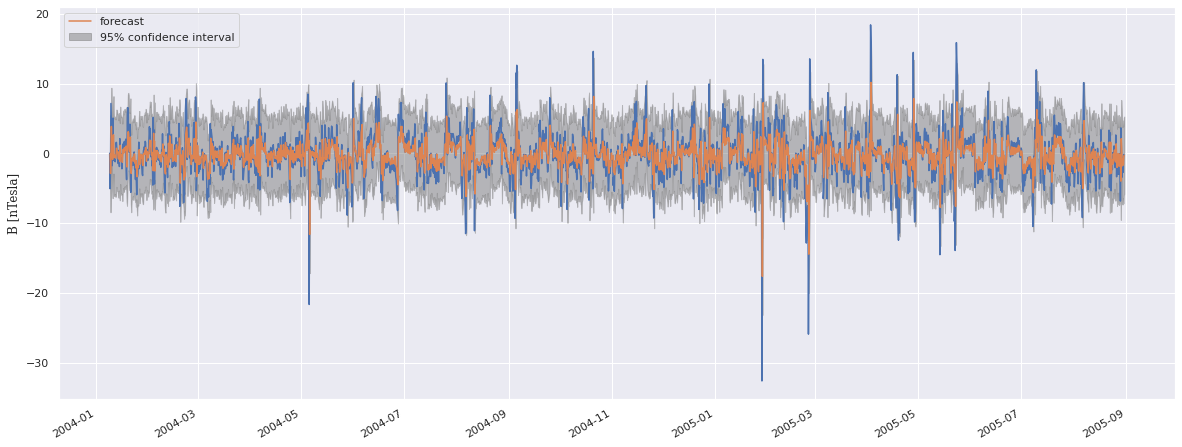

In [69]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(docemeses_resample[variable])
fig = plot_predict(ma1_model, start=1,end=2400, ax=ax)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.show()

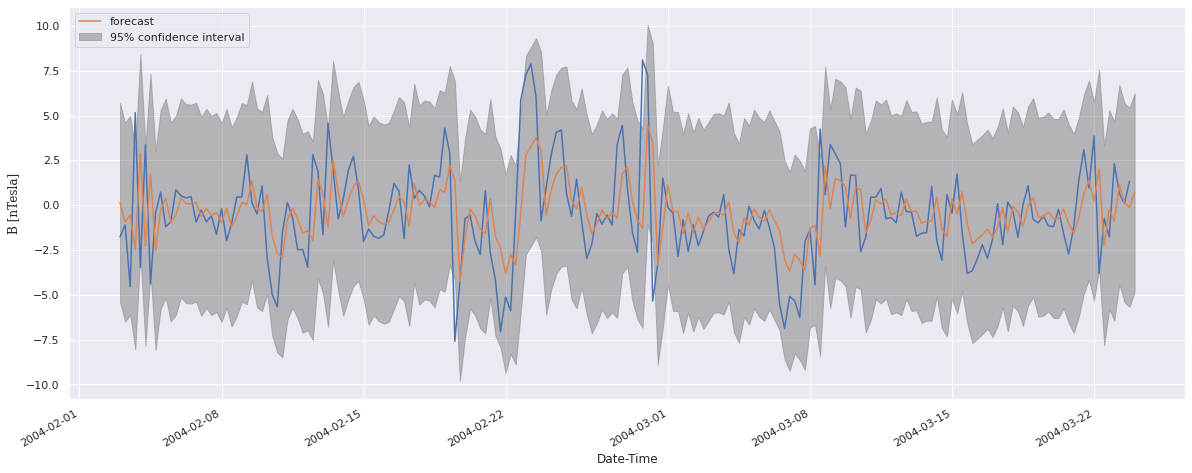

In [70]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(docemeses_resample[variable][100:300])
fig = plot_predict(ma1_model, start=100,end=300, ax=ax)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.show()

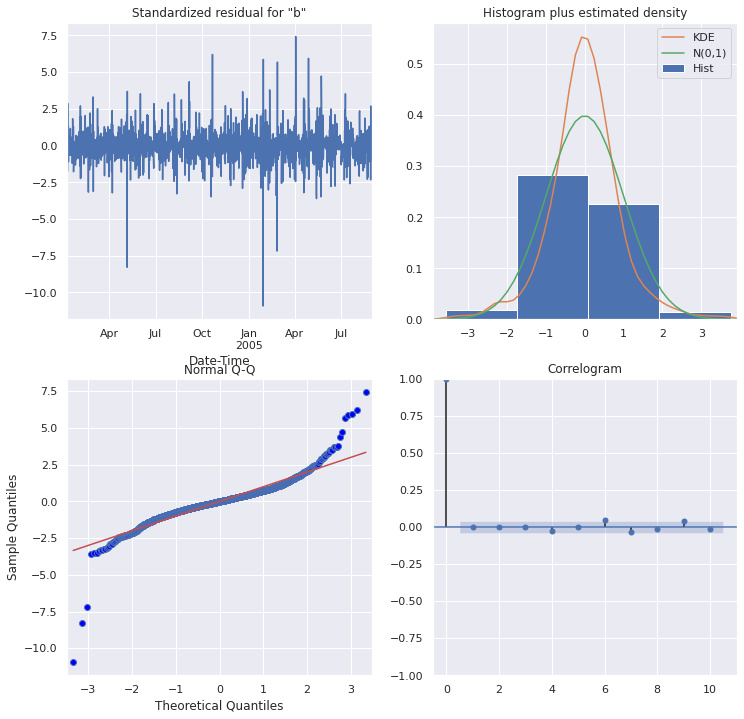

In [57]:
ma1_model.plot_diagnostics(figsize=(12,12))
plt.show()

###4.2 - Model 2
AR = 1, MA = 2

In [58]:
ma2 = ARIMA(docemeses_resample[variable], order=(1, 0, 2))
ma2_model = ma2.fit()
print(ma2_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 bz_gse   No. Observations:                 2400
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -5905.617
Date:                Wed, 12 Oct 2022   AIC                          11821.234
Time:                        12:36:22   BIC                          11850.150
Sample:                    01-09-2004   HQIC                         11831.754
                         - 08-30-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2201      0.128     -1.721      0.085      -0.471       0.031
ar.L1          0.5680      0.042     13.444      0.000       0.485       0.651
ma.L1         -0.0194      0.043     -0.450      0.6

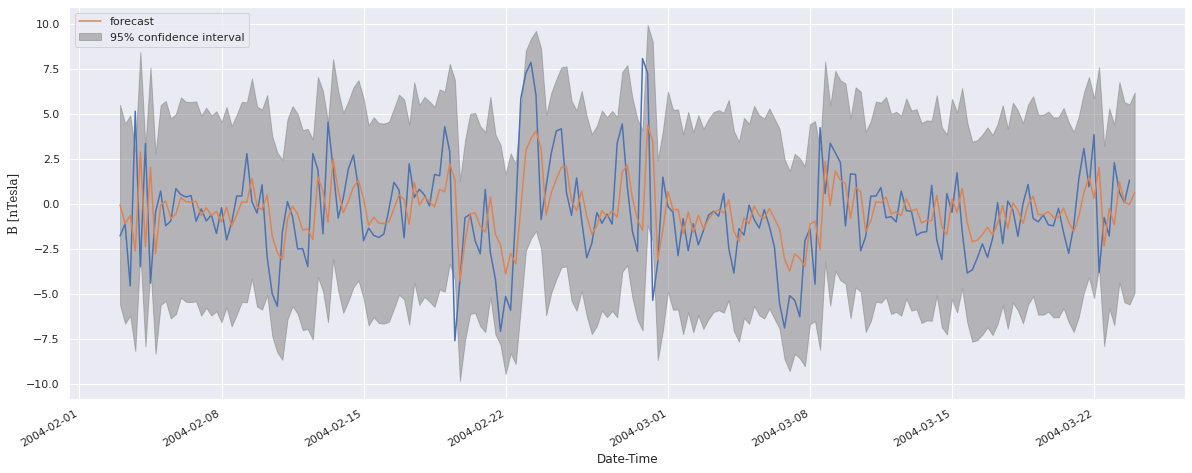

In [71]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(docemeses_resample[variable][100:300])
fig = plot_predict(ma2_model, start=100,end=300, ax=ax)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.show()

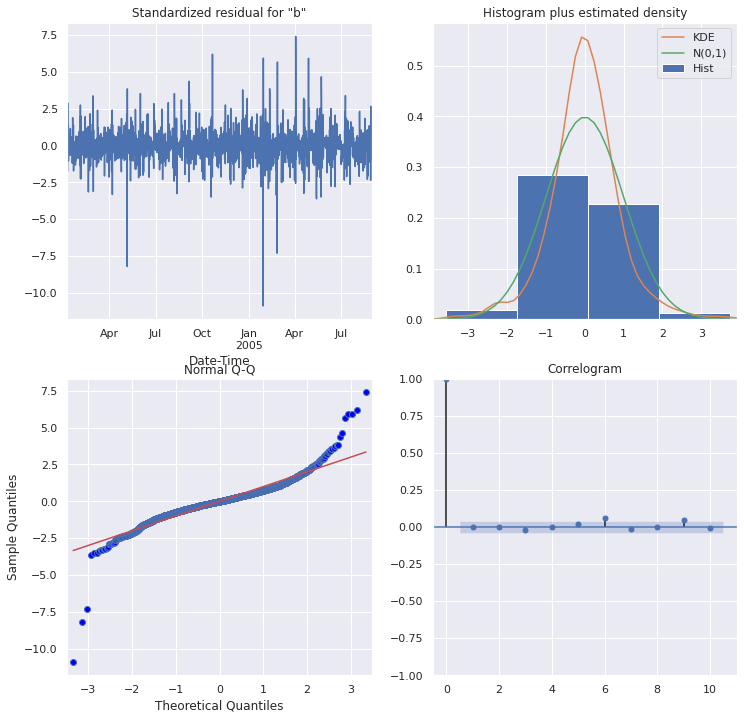

In [60]:
ma2_model.plot_diagnostics(figsize=(12,12))
plt.show()

###4.3 - Model 3

In [61]:
ma3 = ARIMA(docemeses_resample[variable], order=(1, 0, 2), seasonal_order=(1,0,1,3))
ma3_model = ma3.fit()
print(ma3_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            bz_gse   No. Observations:                 2400
Model:             ARIMA(1, 0, 2)x(1, 0, [1], 3)   Log Likelihood               -5902.547
Date:                           Wed, 12 Oct 2022   AIC                          11819.095
Time:                                   12:36:28   BIC                          11859.577
Sample:                               01-09-2004   HQIC                         11833.822
                                    - 08-30-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2201      0.136     -1.614      0.107      -0.487       0.047
ar.L1          0.6965      0.046     15.204

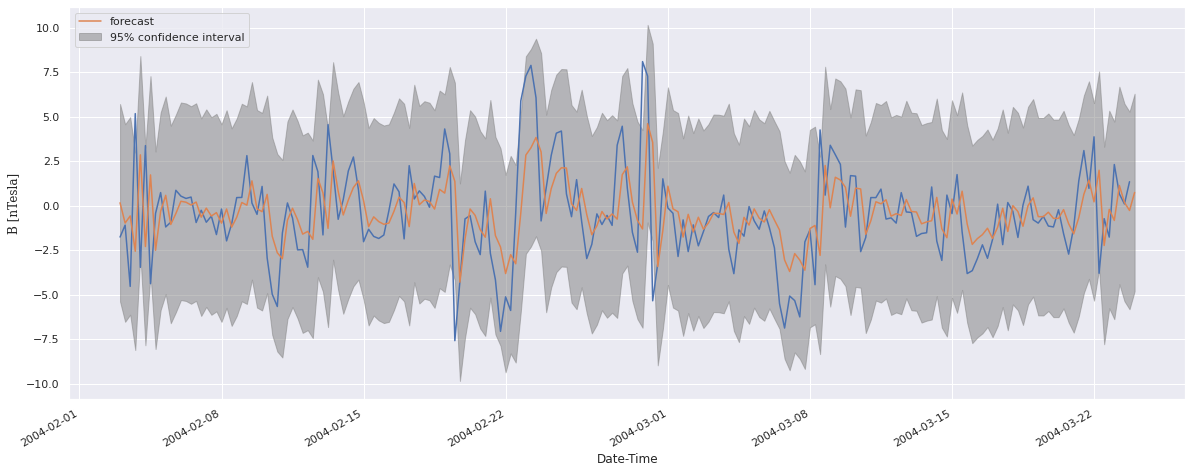

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(docemeses_resample[variable][100:300])
fig = plot_predict(ma3_model, start=100,end=300, ax=ax)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.show()

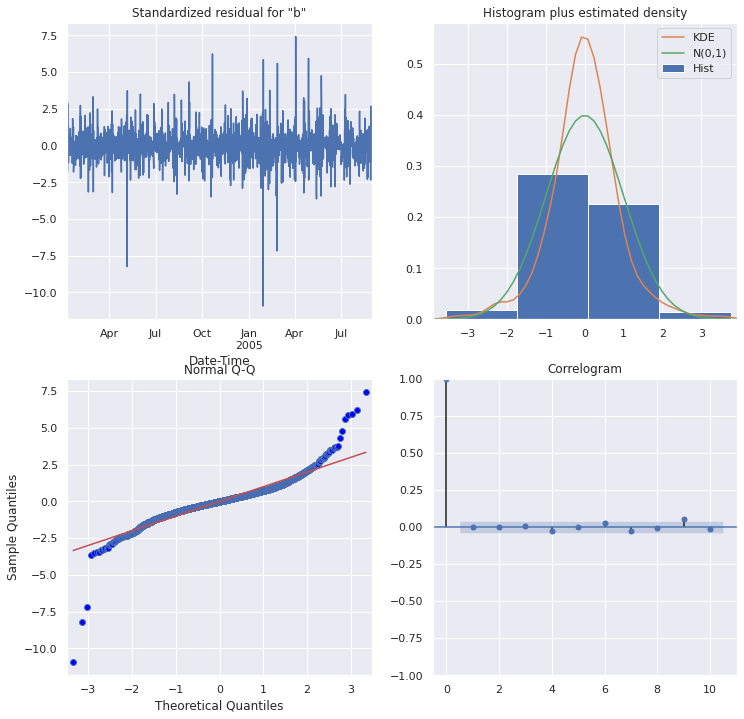

In [63]:
ma3_model.plot_diagnostics(figsize=(12,12))
plt.show()

###4.4 - Predictions with SARIMA model

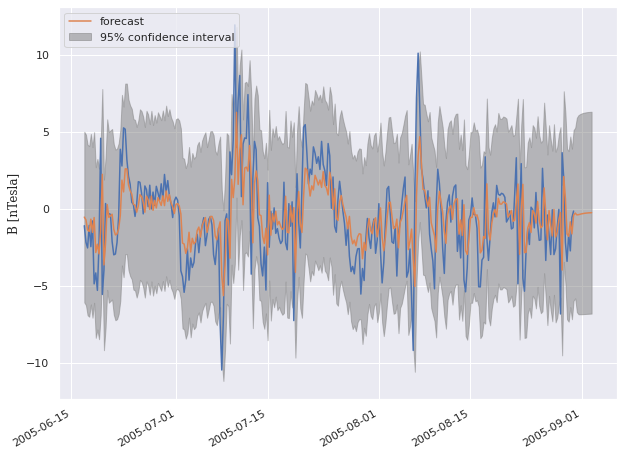

In [73]:
# Predict
N=len(docemeses_resample[variable])
y_arma = ARIMA(docemeses_resample[variable], order=(1, 0, 3))
y_arma_res = y_arma.fit()
#print(y_arma_res.summary())
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(docemeses_resample[variable][N-300:N])
fig = plot_predict(y_arma_res, start=N-300,end=N+10, ax=ax)
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.show()


##5 - LSTM

In [65]:
# LSTM for international airline passengers problem with window regression framing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = docemeses_resample[[variable]]
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
#plt.show()

Epoch 1/100
1604/1604 - 5s - loss: 0.0271 - 5s/epoch - 3ms/step
Epoch 2/100
1604/1604 - 2s - loss: 0.0035 - 2s/epoch - 1ms/step
Epoch 3/100
1604/1604 - 2s - loss: 0.0035 - 2s/epoch - 1ms/step
Epoch 4/100
1604/1604 - 2s - loss: 0.0034 - 2s/epoch - 1ms/step
Epoch 5/100
1604/1604 - 2s - loss: 0.0033 - 2s/epoch - 1ms/step
Epoch 6/100
1604/1604 - 2s - loss: 0.0033 - 2s/epoch - 1ms/step
Epoch 7/100
1604/1604 - 2s - loss: 0.0033 - 2s/epoch - 1ms/step
Epoch 8/100
1604/1604 - 2s - loss: 0.0032 - 2s/epoch - 1ms/step
Epoch 9/100
1604/1604 - 2s - loss: 0.0031 - 2s/epoch - 1ms/step
Epoch 10/100
1604/1604 - 2s - loss: 0.0031 - 2s/epoch - 1ms/step
Epoch 11/100
1604/1604 - 2s - loss: 0.0031 - 2s/epoch - 1ms/step
Epoch 12/100
1604/1604 - 2s - loss: 0.0031 - 2s/epoch - 1ms/step
Epoch 13/100
1604/1604 - 2s - loss: 0.0030 - 2s/epoch - 1ms/step
Epoch 14/100
1604/1604 - 2s - loss: 0.0030 - 2s/epoch - 1ms/step
Epoch 15/100
1604/1604 - 2s - loss: 0.0030 - 2s/epoch - 1ms/step
Epoch 16/100
1604/1604 - 2s - loss

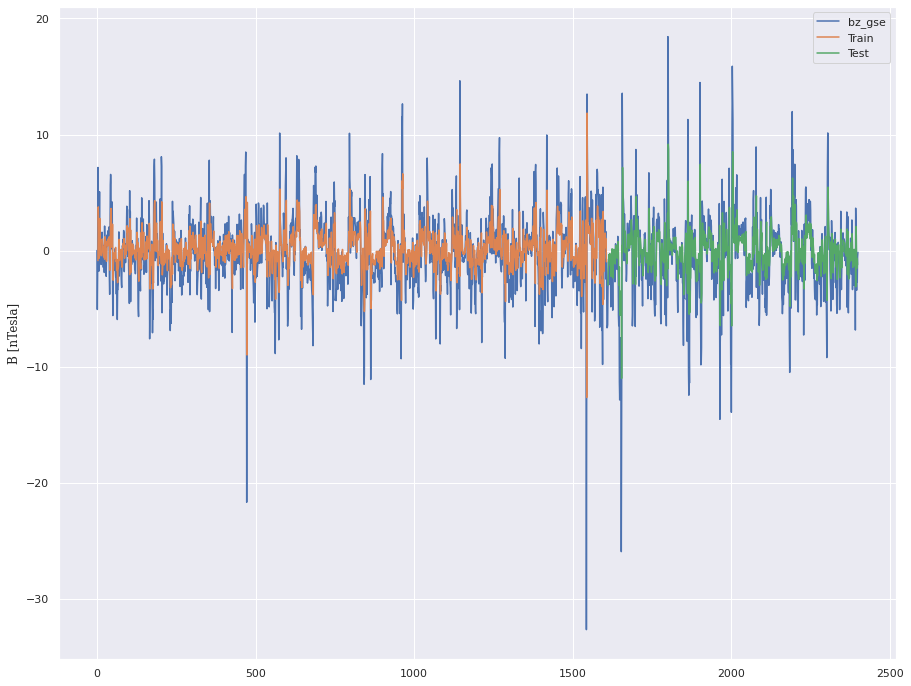

In [79]:
plt.plot(scaler.inverse_transform(dataset), label=variable)
plt.plot(trainPredictPlot, label="Train")
plt.plot(testPredictPlot, label="Test")
plt.ylabel("B [nTesla]", family='serif', weight='normal', size = 12, labelpad = 6)
legend = ax.legend(loc="upper left")
plt.legend()
plt.show()

##6 - Conclutions


* Due to the nature of the stationary movement of the satellite, it is expected that the measurements taken by it will have a stationary behavior.
* The dataset contains more than 8 million records, with 14 measurements. By containing so many records (1 every minute) to process this size of data, it entails the need for more computing capacity. To circumvent this problem, a resampling based on 6 hours was performed. In turn, taking advantage of the fact that the dataset is divided into 3 sections, it was decided to perform the analysis on only 1 of these sections. The dataset is limited to 1 year, to facilitate the processing of the series.
* The variable *bz_gse* was selected = interplanetary magnetic field in the z axis, that is, perpendicular to the elliptical and is created by waves and other disturbances in the solar wind.
* The distribution of the measurements of the variable is close to a Gaussian distribution, although it has long tails. When performing a QQplot, these values ​​are observed in the tails, as outliers.
* When analyzing the frequency spectrum, components are obtained mainly at 1, 2, and 4 Hz.
* When carrying out additive decompositions, it is observed that the trend contains cyclical characteristics, and if successive decompositions continue, only a "smoothing" of the trend is obtained, but the cyclical component is not eliminated. It could be verified by differentiating the variable, but due to lack of time due to the replacement of the dataset in the middle of the course, it was decided not to delve further in this regard.
* Autocorrelation shows exponential decay, with 2 lags outside the confidence zone. This hints at stationary behavior.
* The partial autocorrelation shows a single lag outside the confidence zone and no cyclical components are observed to consider differentiating the series.
* Both the Dickey-Fuller test and the KPSS show that the series is stationary.
* Some SARIMA models were simulated, modifying their p and q coefficients. It is decided to use the model AR=1, MA=3 for the prediction of future values.
* The prediction is plotted 10 steps into the future, not obtaining oscillations, such as those observed in the measurements.
* An LTSM model is trained to predict the future behavior of the variable.
